In [507]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import scipy

from sklearn.metrics import RocCurveDisplay
from sklearn import metrics


## Hosmer- Lemshow Chi-Squared Test

$HL = \sum_{j=1}^g\frac{(O_j-n_j\pi_j)^2}{n_j\pi_j(1-\pi_j)}$

In [508]:
#The null hypothesis is that the observed and expected proportions are the same across all doses. The alternative hypothesis is that the observed and expected proportions are not the same.
def hosmer_lemshow(prob, y, sizes):
    HL = 0
    for bucket in zip(prob, y, sizes):
        n_j = bucket[2]
        O_j = bucket[2] * bucket[1]
        pi_j = bucket[0]
        HL += (O_j - pi_j*n_j)**2/(n_j*pi_j*(1-pi_j))
    p_value = 1 - stats.chi2.cdf(HL , len(y) - 2)
    return p_value

## Utils

In [509]:
def color_test(p_value):
    p_value = round(p_value,2)
    p_value = '\033[32m' + str(p_value) if p_value>0.1 else '\033[33m' + str(p_value) if p_value>0.05 else '\033[31m' + str(p_value)
    p_value += '\033[0m'
    return p_value

In [553]:
def run_experiment(prob, y, buckets=20, fit=True, plot = True, fun = None):
    def get_bucketing(prob, y, buckets):
        # Bucketting based on predicted probabilities
        df = pd.DataFrame(data={"predicted": prob, "real": y})
        df["bucket"] = 0
        for j in range(1,buckets):
            less_range = np.quantile(df.predicted,j/buckets)
            df["bucket"] = [df.bucket[j]+1 if df["predicted"][j]>less_range else df.bucket[j] for j in range(len(df.bucket))]
        stats_for_bucket = df.groupby('bucket').mean()
        stats_for_bucket["size"] = df.groupby('bucket').count()["predicted"]
        return stats_for_bucket
    stats_for_bucket = get_bucketing(prob, y, buckets)

    if plot:
        # Plot realised vs observed probabilities
        fig, ax = plt.subplots(1,2, figsize=(12, 6))
        
        ax[0].plot([0,1],[0,1], color="maroon", label="Expected")

        # Best fit
        if fit:
            x = np.linspace(np.min(stats_for_bucket.predicted),np.max(stats_for_bucket.predicted),100)
            def fit_func(x, a, b, c, d, e):
                return (a/(1+np.exp(-b*(x-c)))+d+e*x)
            a = np.max(stats_for_bucket.real)
            b = 4
            c = np.median(stats_for_bucket.predicted)
            d = np.min(stats_for_bucket.real)
            e = 0
            fit, _ = scipy.optimize.curve_fit(fit_func, stats_for_bucket.predicted, stats_for_bucket.real,[a, b, c, d, e])
            p = lambda x: fit_func(x,*fit)

            ax[0].plot(x,[p(x) for x in x], color="green", label="Best fit")
        elif fun != None:
            x = np.linspace(np.min(stats_for_bucket.predicted),np.max(stats_for_bucket.predicted),100)
            ax[0].plot(x,[fun(x) for x in x], color="blue", label="Real")
        ax[0].scatter(stats_for_bucket.predicted, stats_for_bucket.real, color="gold")
        ax[0].set_xlabel("Predicted")
        ax[0].set_ylabel("Real")
        ax[0].legend()

        # ROC
        dis = RocCurveDisplay.from_predictions(
            y,
            prob,
            name=f"Discriminatory power",
            color="darkorange",
            ax=ax[1]
        )
        _ = dis.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title="Discriminatory power",
        )
        ax[1].plot([0,1],[0,1], color="maroon")
        plt.show()

        print(f"Best sigmoid: {fit}\n")

        # Statistical test

        ## Wilcoxon-signed rank
        print(f"Wilcoxon scipy:\nOne sided: {color_test(stats.wilcoxon(stats_for_bucket.predicted, stats_for_bucket.real, alternative='greater')[1])}\nTwo sided: {color_test(stats.wilcoxon(stats_for_bucket.predicted, stats_for_bucket.real)[1])}\n")

        ## T-test
        print(f"T-test scipy:\nOne sided: {color_test(stats.ttest_ind(prob, y, alternative='greater')[1])}\nTwo sided: {color_test(stats.ttest_ind(prob, y)[1])}\n")

        ## Hosmer-Lemshow
        print(f"Hosmer-Lemshow:\nTwo sided: {color_test(hosmer_lemshow(stats_for_bucket.predicted, stats_for_bucket.real, stats_for_bucket['size']))}\n" )

        ## Kolmogorow-Smirnov- for some reason I believe alternative hypothesis is reversed when comparing to other tests
        print(f"Kolmogorow-Smirnov:\nOne sided: {color_test(stats.ks_2samp(stats_for_bucket.predicted, stats_for_bucket.real, alternative='less')[1])}\nTwo sided: {color_test(stats.ks_2samp(stats_for_bucket.predicted, stats_for_bucket.real).pvalue)}\n" )

        # Mean squared error
        print(f"MSE: {np.mean((stats_for_bucket.predicted-stats_for_bucket.real)**2)}")
        
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(prob.reshape(-1,1), y, test_size=0.5, random_state=42)    
    
    # Fit Platt scaling (logistic calibration)
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    calibrated_platt = lr.predict_proba(X_test)[:,1]
    stats_for_bucket_platt = get_bucketing(calibrated_platt, y_test, buckets)

    # Isotonic regression (non-parametric calibration)
    from sklearn.calibration import IsotonicRegression
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(X_train, y_train)
    calibrated_iso = iso.predict(X_test)
    stats_for_bucket_iso = get_bucketing(calibrated_iso, y_test, buckets)
    
    auc = [metrics.roc_auc_score(y, prob), metrics.roc_auc_score(y_test, calibrated_platt), metrics.roc_auc_score(y_test, calibrated_iso)]
    ece = np.round([np.abs(stats_for_bucket.predicted - stats_for_bucket.real).mean(), np.abs(stats_for_bucket_platt.predicted - stats_for_bucket_platt.real).mean(), np.abs(stats_for_bucket_iso.predicted - stats_for_bucket_iso.real).mean()],3)
    log_loss = [metrics.log_loss(y, prob), metrics.log_loss(y_test, calibrated_platt), metrics.log_loss(y_test, calibrated_iso)]
    brier_score = [metrics.brier_score_loss(y, prob), metrics.brier_score_loss(y_test, calibrated_platt), metrics.brier_score_loss(y_test, calibrated_iso)]
    spearman = [stats.spearmanr(stats_for_bucket.predicted, stats_for_bucket.real)[0], stats.spearmanr(stats_for_bucket_platt.predicted, stats_for_bucket_platt.real)[0], stats.spearmanr(stats_for_bucket_iso.predicted, stats_for_bucket_iso.real)[0]]
    result = pd.DataFrame(data={"log_loss": log_loss, "brier_score": brier_score, "ECE":ece, "AUC":auc, "spearman": spearman}, index=["original", "platt", "iso"])
    

    display(result)
    return result

    

In [511]:
def just_p_values(prob, y, buckets=20, p_values = None):
    # Bucketting based on predicted probabilities
    df = pd.DataFrame(data={"predicted": prob, "real": y})
    df["bucket"] = 0
    for j in range(1,buckets):
        less_range = np.quantile(df.predicted,j/buckets)
        df["bucket"] = [df.bucket[j]+1 if df["predicted"][j]>less_range else df.bucket[j] for j in range(len(df.bucket))]
    stats_for_bucket = df.groupby('bucket').mean()
    stats_for_bucket["size"] = df.groupby('bucket').count()["predicted"]

    # Statistical test
    if p_values == None:
        p_values = {key:[] for key in ["Wilcoxon One sided", "Wilcoxon Two sided", "T-test One sided", "T-test Two sided", "Hosmer-Lemshow Two sided", "Kolmogorow-Smirnov One sided", "Kolmogorow-Smirnov Two sided"]}
    
    ## Wilcoxon-signed rank
    p_values["Wilcoxon One sided"].append(stats.wilcoxon(stats_for_bucket.predicted, stats_for_bucket.real, alternative='greater')[1])
    p_values["Wilcoxon Two sided"].append(stats.wilcoxon(stats_for_bucket.predicted, stats_for_bucket.real)[1])
    
    ## T-test
    p_values["T-test One sided"].append(stats.ttest_ind(prob, y, alternative='greater')[1])
    p_values["T-test Two sided"].append(stats.ttest_ind(prob, y)[1])
    
    ## Hosmer-Lemshow
    p_values["Hosmer-Lemshow Two sided"].append(hosmer_lemshow(stats_for_bucket.predicted, stats_for_bucket.real, stats_for_bucket["size"]))
    
    ## Kolmogorow-Smirnov
    p_values["Kolmogorow-Smirnov One sided"].append(stats.ks_2samp(stats_for_bucket.predicted, stats_for_bucket.real, alternative='less')[1])
    p_values["Kolmogorow-Smirnov Two sided"].append(stats.ks_2samp(stats_for_bucket.predicted, stats_for_bucket.real)[1])
    
    return p_values

## Variables

In [512]:
# Sample size for all experiments
n = 1000

# Number of buckets for all experiments
buckets = 20

In [513]:
results = []

# Calibrated model

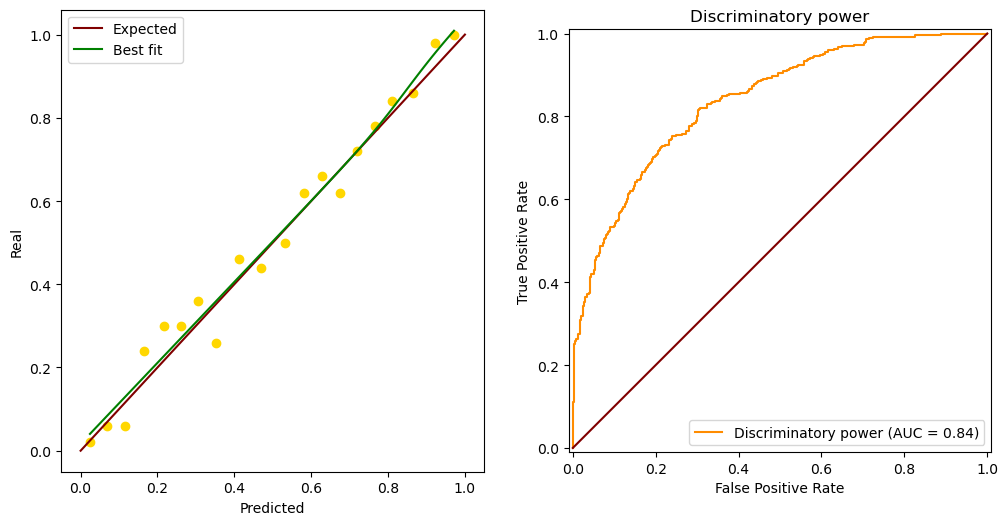

Best sigmoid: [5.23455503e-02 1.93123605e+01 8.48443124e-01 1.67886337e-02
 9.72232088e-01]

Wilcoxon scipy:
One sided: 0.84
Two sided: 0.33

T-test scipy:
One sided: 0.72
Two sided: 0.56

Hosmer-Lemshow:
Two sided: 0.67

Kolmogorow-Smirnov:
One sided: 0.82
Two sided: 1.0

MSE: 0.0021860223041642807


,log_loss,brier_score,ECE,AUC,spearman
original,0.491004,0.164216,0.039,0.838250,0.986075
platt,0.506956,0.167821,0.066,0.836040,0.987558
iso,0.495757,0.167282,0.060,0.834374,0.984808


In [514]:
# Sample generation
prob = np.random.uniform(0,1,n)
y = ((prob + np.random.uniform(-1/2,1/2,n))>1/2).astype(int)

res = run_experiment(prob, y, buckets)
res["Name"] = "Calibrated"
results.append(res)


In [515]:

#

In [516]:
# p_values = None
# for _ in range(100):
#     prob = np.random.uniform(0,1,n)
#     y = ((prob + np.random.uniform(-1/2,1/2,n))>1/2).astype(int)

#     p_values = just_p_values(prob, y, buckets, p_values) 
# p_values = pd.DataFrame(p_values)

# fig, ax = plt.subplots(figsize=(8,4))
# sns.boxplot(ax=ax,
#                data = p_values)
# plt.xticks(rotation=45, ha='right')
# plt.hlines([0.05,0.1],-1/2,p_values.shape[1]-1/2, colors=["Red","Gold"])
# plt.show()


# Model biased favoring class 1

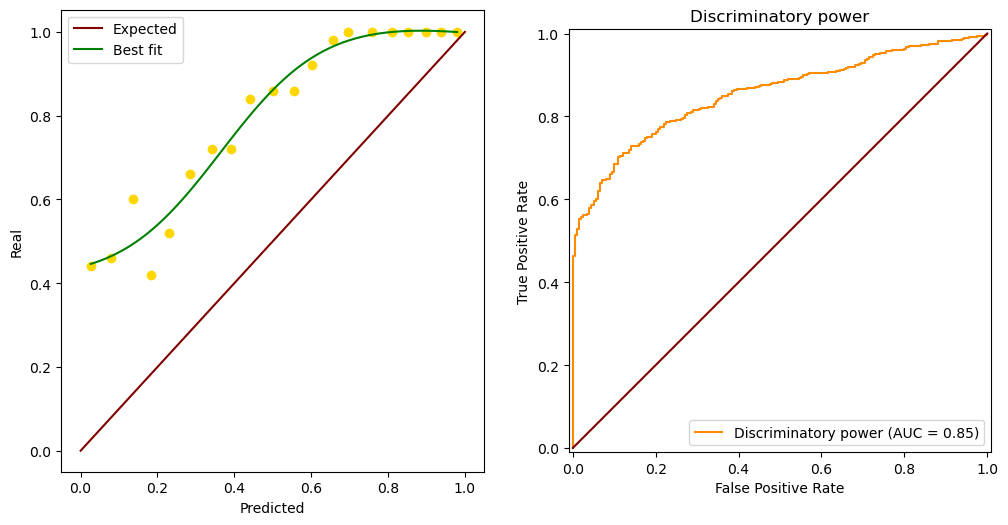

Best sigmoid: [ 0.75431951  6.97932473  0.36530826  0.3847726  -0.13191321]

Wilcoxon scipy:
One sided: 1.0
Two sided: 0.0

T-test scipy:
One sided: 1.0
Two sided: 0.0

Hosmer-Lemshow:
Two sided: 0.0

Kolmogorow-Smirnov:
One sided: 1.0
Two sided: 0.08

MSE: 0.09360499698637857


,log_loss,brier_score,ECE,AUC,spearman
original,0.642218,0.209687,0.282,0.854369,0.965651
platt,0.363284,0.118051,0.055,0.846342,0.941074
iso,0.357467,0.122034,0.057,0.841559,0.892857


In [517]:
# Sample generation
prob = np.random.uniform(0,1,n)
y = ((prob + np.random.uniform(-1/2,1/2,n) + 1/3)>1/2).astype(int)

res = run_experiment(prob, y, buckets)
res["Name"] = "Biased towards 1"
results.append(res)

In [518]:
# p_values = None
# for _ in range(100):
#     prob = np.random.uniform(0,1,n)
#     y = ((prob + np.random.uniform(-1/2,1/2,n) + 1/3)>1/2).astype(int)

#     p_values = just_p_values(prob, y, buckets, p_values) 
# p_values = pd.DataFrame(p_values)

# fig, ax = plt.subplots(figsize=(8,4))
# sns.boxplot(ax=ax,
#                data = p_values)
# plt.xticks(rotation=45, ha='right')
# plt.hlines([0.05,0.1],-1/2,p_values.shape[1]-1/2, colors=["Red","Gold"])
# plt.show()

#  Model biased favoring class 0

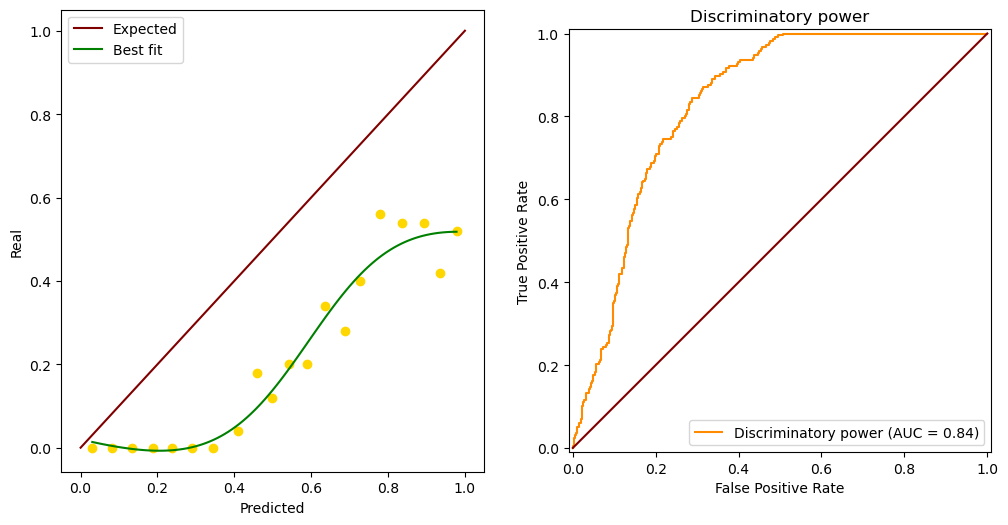

Best sigmoid: [ 0.80934058  7.89290991  0.5931      0.01253112 -0.27298917]

Wilcoxon scipy:
One sided: 0.0
Two sided: 0.0

T-test scipy:
One sided: 0.0
Two sided: 0.0

Hosmer-Lemshow:
Two sided: 0.0

Kolmogorow-Smirnov:
One sided: 0.02
Two sided: 0.03

MSE: 0.10229408724179975


,log_loss,brier_score,ECE,AUC,spearman
original,0.702913,0.228007,0.297,0.835508,0.947199
platt,0.412062,0.138845,0.083,0.830594,0.921188
iso,0.389276,0.134833,0.083,0.830235,0.750000


In [519]:
# Sample generation
prob = np.random.uniform(0,1,n)
y = ((prob + np.random.uniform(-1/2,1/2,n) - 1/3)>1/2).astype(int)

res = run_experiment(prob, y, buckets)
res["Name"] = "Biased towards 0"
results.append(res)

In [520]:
# p_values = None
# for _ in range(100):
#     prob = np.random.uniform(0,1,n)
#     y = ((prob + np.random.uniform(-1/2,1/2,n) - 1/3)>1/2).astype(int)

#     p_values = just_p_values(prob, y, buckets, p_values) 
# p_values = pd.DataFrame(p_values)

# fig, ax = plt.subplots(figsize=(8,4))
# sns.boxplot(ax=ax,
#                data = p_values)
# plt.xticks(rotation=45, ha='right')
# plt.hlines([0.05,0.1],-1/2,p_values.shape[1]-1/2, colors=["Red","Gold"])
# plt.show()

# Overfitted model

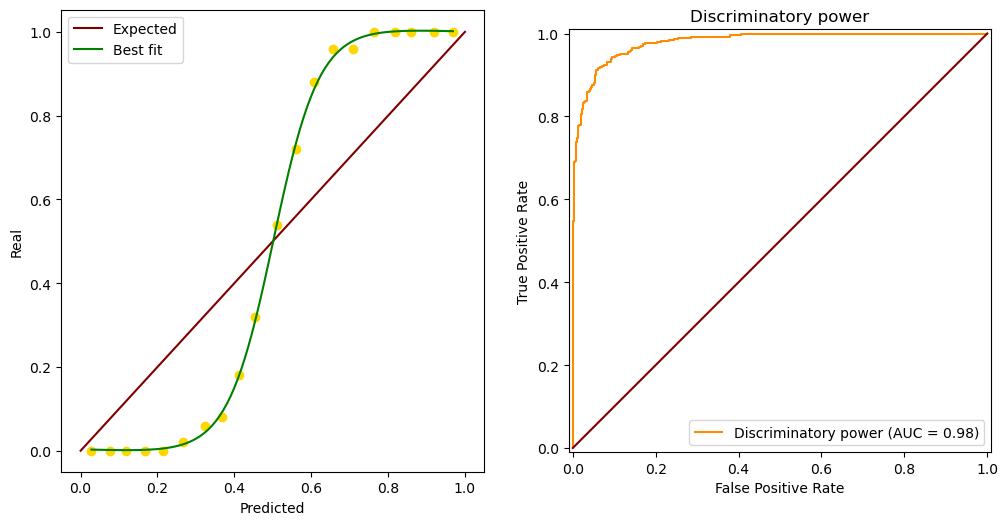

Best sigmoid: [ 1.02666754e+00  1.67262139e+01  5.01591384e-01  3.12858765e-03
 -2.85705345e-02]

Wilcoxon scipy:
One sided: 0.51
Two sided: 1.0

T-test scipy:
One sided: 0.41
Two sided: 0.81

Hosmer-Lemshow:
Two sided: 0.0

Kolmogorow-Smirnov:
One sided: 0.17
Two sided: 0.34

MSE: 0.037617380892640155


,log_loss,brier_score,ECE,AUC,spearman
original,0.330846,0.094485,0.173,0.979808,0.984466
platt,0.230504,0.061538,0.103,0.985477,0.950683
iso,0.161236,0.049188,0.036,0.984545,0.975628


In [521]:
# Sample generation
prob = np.random.uniform(0,1,n)
y = ((prob + np.random.normal(0,1/10,n))>1/2).astype(int)

res = run_experiment(prob, y, buckets)
res["Name"] = "Overfitted"
results.append(res)


In [522]:
# p_values = None
# for _ in range(100):
#     prob = np.random.uniform(0,1,n)
#     y = ((prob + np.random.normal(0,1/10,n))>1/2).astype(int)

#     p_values = just_p_values(prob, y, buckets, p_values) 
# p_values = pd.DataFrame(p_values)

# fig, ax = plt.subplots(figsize=(8,4))
# sns.boxplot(ax=ax,
#                data = p_values)
# plt.xticks(rotation=45, ha='right')
# plt.hlines([0.05,0.1],-1/2,p_values.shape[1]-1/2, colors=["Red","Gold"])
# plt.show()

# Underfitted model

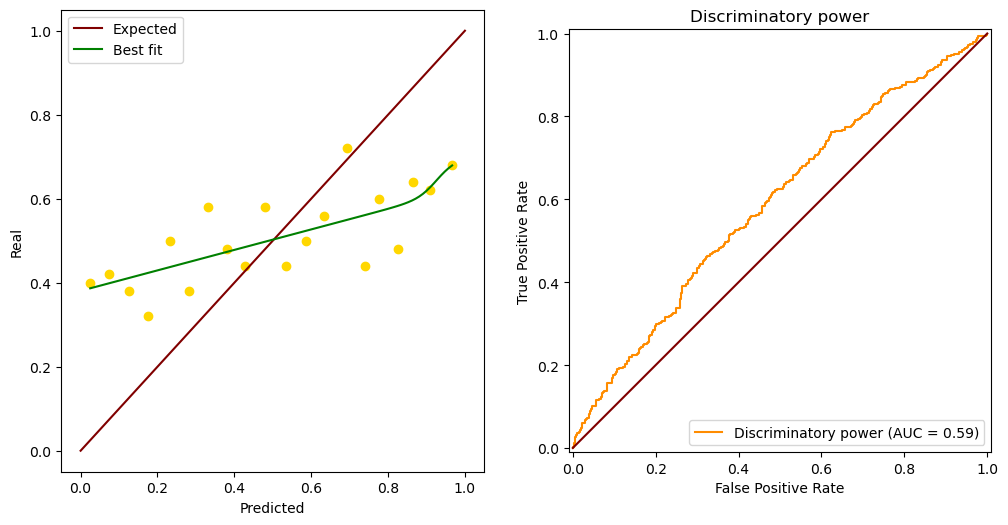

Best sigmoid: [ 0.07425938 41.95299808  0.92594104  0.3806224   0.24382597]

Wilcoxon scipy:
One sided: 0.59
Two sided: 0.84

T-test scipy:
One sided: 0.6
Two sided: 0.79

Hosmer-Lemshow:
Two sided: 0.0

Kolmogorow-Smirnov:
One sided: 0.17
Two sided: 0.34

MSE: 0.049397771723500315


,log_loss,brier_score,ECE,AUC,spearman
original,0.855724,0.288255,0.192,0.588395,0.742085
platt,0.679735,0.243343,0.064,0.600634,0.753157
iso,0.684375,0.245455,0.081,0.599386,0.714286


In [523]:
# Sample generation
prob = np.random.uniform(0,1,n)
y = ((prob + np.random.normal(0,2,n))>1/2).astype(int)

res = run_experiment(prob, y, buckets)
res["Name"] = "Underfitted"
results.append(res)

In [524]:
# p_values = None
# for _ in range(100):
#     prob = np.random.uniform(0,1,n)
#     y = ((prob + np.random.normal(0,2,n))>1/2).astype(int)

#     p_values = just_p_values(prob, y, buckets, p_values) 
# p_values = pd.DataFrame(p_values)

# fig, ax = plt.subplots(figsize=(8,4))
# sns.boxplot(ax=ax,
#                data = p_values)
# plt.xticks(rotation=45, ha='right')
# plt.hlines([0.05,0.1],-1/2,p_values.shape[1]-1/2, colors=["Red","Gold"])
# plt.show()

In [525]:
# Last model has highest discriminatory power this is probably why neural networks are uncalibrated models because they focus on discriminatory power
# Try focal loss

In [526]:
# iso

In [527]:
df = pd.concat(results)
df

,log_loss,brier_score,ECE,AUC,spearman,Name
original,0.491004,0.164216,0.039,0.838250,0.986075,Calibrated
platt,0.506956,0.167821,0.066,0.836040,0.987558,Calibrated
iso,0.495757,0.167282,0.060,0.834374,0.984808,Calibrated
original,0.642218,0.209687,0.282,0.854369,0.965651,Biased towards 1
platt,0.363284,0.118051,0.055,0.846342,0.941074,Biased towards 1
iso,0.357467,0.122034,0.057,0.841559,0.892857,Biased towards 1
original,0.702913,0.228007,0.297,0.835508,0.947199,Biased towards 0
platt,0.412062,0.138845,0.083,0.830594,0.921188,Biased towards 0
iso,0.389276,0.134833,0.083,0.830235,0.750000,Biased towards 0
original,0.330846,0.094485,0.173,0.979808,0.984466,Overfitted


In [528]:
df[df.index == "original"]

,log_loss,brier_score,ECE,AUC,spearman,Name
original,0.491004,0.164216,0.039,0.838250,0.986075,Calibrated
original,0.642218,0.209687,0.282,0.854369,0.965651,Biased towards 1
original,0.702913,0.228007,0.297,0.835508,0.947199,Biased towards 0
original,0.330846,0.094485,0.173,0.979808,0.984466,Overfitted
original,0.855724,0.288255,0.192,0.588395,0.742085,Underfitted


In [529]:
df[[ "ECE", "spearman", "Name"]]

,ECE,spearman,Name
original,0.039,0.986075,Calibrated
platt,0.066,0.987558,Calibrated
iso,0.060,0.984808,Calibrated
original,0.282,0.965651,Biased towards 1
platt,0.055,0.941074,Biased towards 1
iso,0.057,0.892857,Biased towards 1
original,0.297,0.947199,Biased towards 0
platt,0.083,0.921188,Biased towards 0
iso,0.083,0.750000,Biased towards 0
original,0.173,0.984466,Overfitted


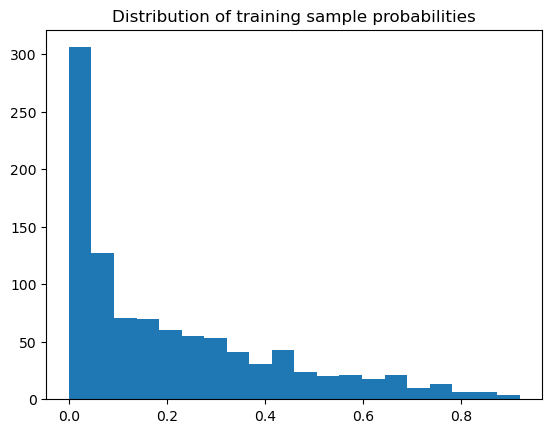

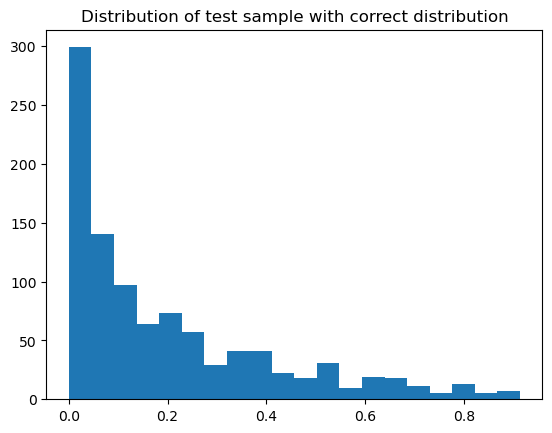

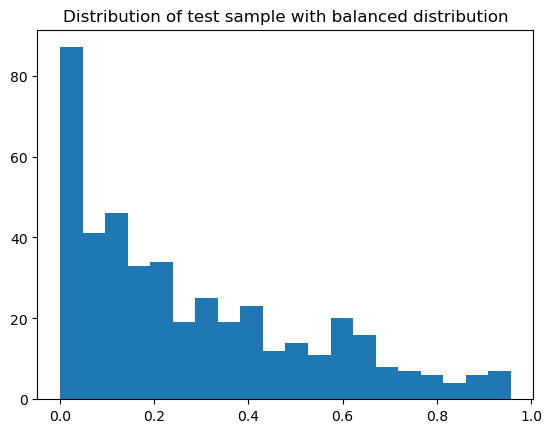

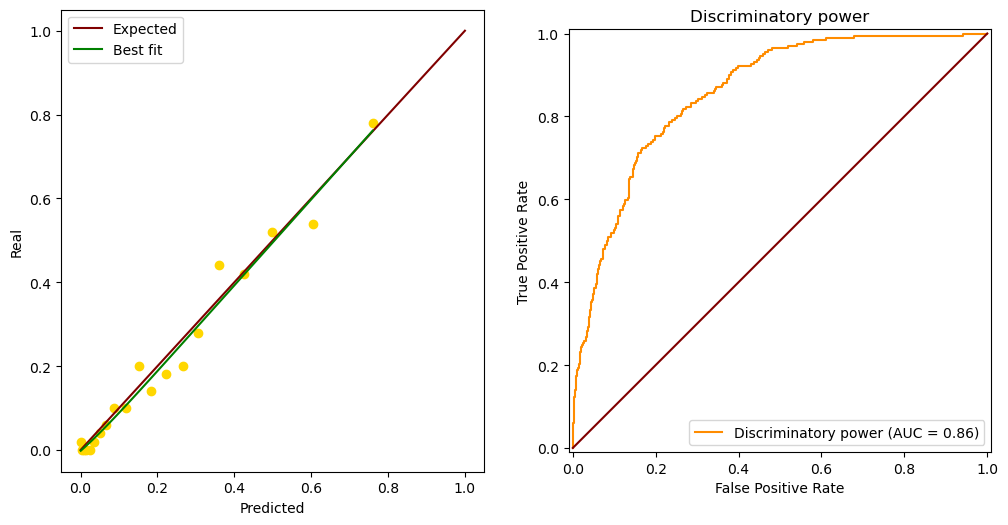

Best sigmoid: [-16.59455505  14.55982294  -0.47955445  16.57703535   1.02509741]

Wilcoxon scipy:
One sided: 0.15
Two sided: 0.29

T-test scipy:
One sided: 0.31
Two sided: 0.62

Hosmer-Lemshow:
Two sided: 0.0

Kolmogorow-Smirnov:
One sided: 0.46
Two sided: 0.83

MSE: 0.0012462101963440569


,log_loss,brier_score,ECE,AUC,spearman
original,0.356213,0.114026,0.028,0.857583,0.969411
platt,0.373261,0.117056,0.057,0.856375,0.942062
iso,0.428064,0.118401,0.071,0.847713,0.966667


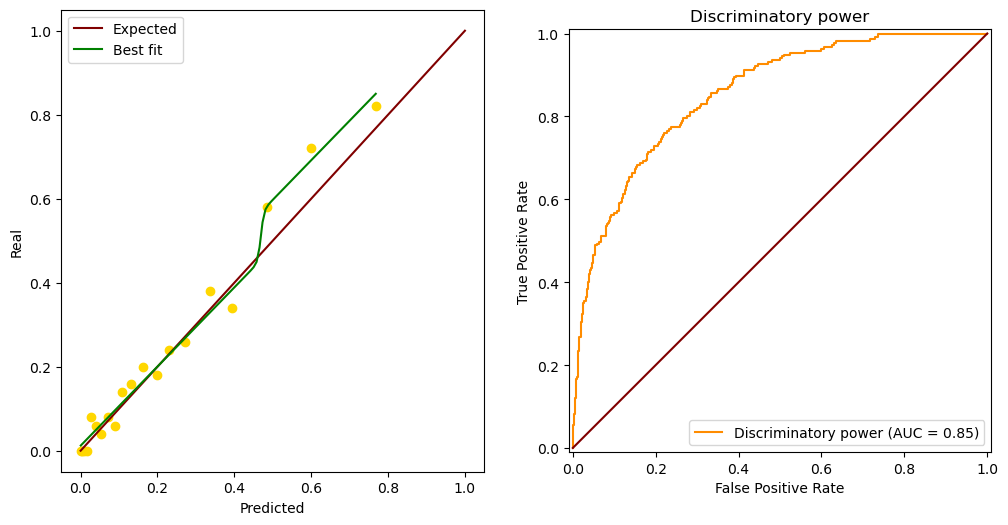

Best sigmoid: [1.14308670e-01 2.55953644e+02 4.69034318e-01 1.19923613e-02
 9.42150273e-01]

Wilcoxon scipy:
One sided: 0.93
Two sided: 0.14

T-test scipy:
One sided: 0.88
Two sided: 0.23

Hosmer-Lemshow:
Two sided: 0.57

Kolmogorow-Smirnov:
One sided: 0.46
Two sided: 0.83

MSE: 0.001996192539053323


,log_loss,brier_score,ECE,AUC,spearman
original,0.367825,0.116818,0.033,0.854824,0.975841
platt,0.396689,0.124841,0.076,0.865032,0.977259
iso,0.505730,0.120431,0.042,0.857377,1.000000


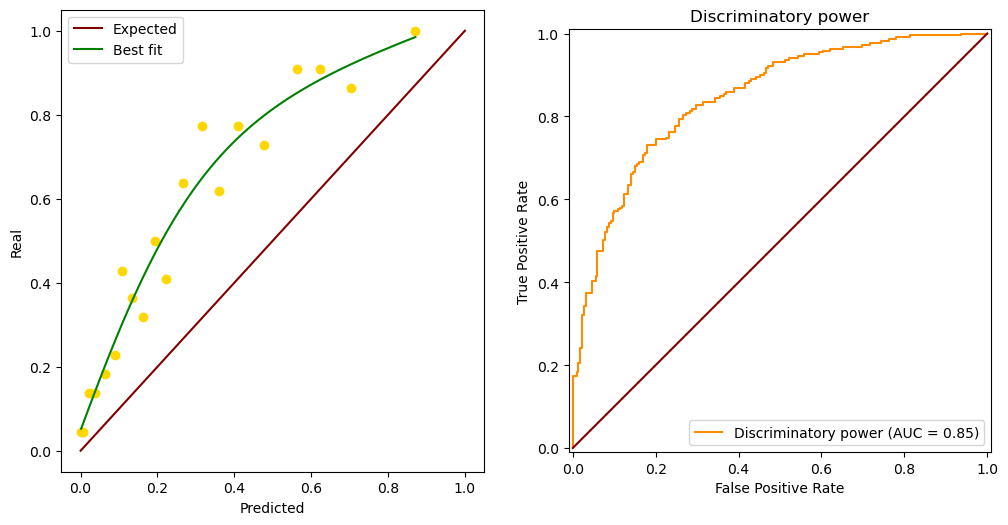

Best sigmoid: [ 1.47583105  5.90458162 -0.03249735 -0.75954261  0.31644722]

Wilcoxon scipy:
One sided: 1.0
Two sided: 0.0

T-test scipy:
One sided: 1.0
Two sided: 0.0

Hosmer-Lemshow:
Two sided: 0.0

Kolmogorow-Smirnov:
One sided: 1.0
Two sided: 0.17

MSE: 0.0609673108900188


,log_loss,brier_score,ECE,AUC,spearman
original,0.643917,0.216974,0.219,0.845708,0.969128
platt,0.532696,0.178748,0.119,0.824635,0.926695
iso,0.538217,0.179925,0.118,0.820691,0.888584


,log_loss,brier_score,ECE,AUC,spearman,Name
original,0.356213,0.114026,0.028,0.857583,0.969411,Train
platt,0.373261,0.117056,0.057,0.856375,0.942062,Train
iso,0.428064,0.118401,0.071,0.847713,0.966667,Train
original,0.367825,0.116818,0.033,0.854824,0.975841,Representative
platt,0.396689,0.124841,0.076,0.865032,0.977259,Representative
iso,0.505730,0.120431,0.042,0.857377,1.000000,Representative
original,0.643917,0.216974,0.219,0.845708,0.969128,Balanced
platt,0.532696,0.178748,0.119,0.824635,0.926695,Balanced
iso,0.538217,0.179925,0.118,0.820691,0.888584,Balanced


In [536]:
# What happends in imbalanced classification problems?
# Sample generation- instead of uniform distribution we will use beta distribution
from scipy.stats import beta
a, b = 0.5, 2
prob = beta.rvs(a, b, size=n)

y = ((prob + np.random.uniform(-1/2,1/2,n))>1/2).astype(int)
plt.hist(prob, bins=20)
plt.title("Distribution of training sample probabilities")
plt.show()
# Now we create 2 test samples, one generated exactlly as the initial sample- with the same beta distribution, the other will also be based on the same distribution, however we will intentionally choose as many instances with 1 target variable as with 0 target variable
# Sample 1
prob1 = beta.rvs(a, b, size=n)
y1 = ((prob1 + np.random.uniform(-1/2,1/2,n))>1/2).astype(int)
plt.hist(prob1, bins=20)
plt.title("Distribution of test sample with correct distribution")
plt.show()
# Sample 2
prob2 = beta.rvs(a, b, size=n)
y2 = ((prob2 + np.random.uniform(-1/2,1/2,n))>1/2).astype(int)
class_1 = prob2[y2==1]
class_0 = prob2[y2==0]
prob2 = np.concatenate([class_1, class_0[:len(class_1)]])
y2 = np.concatenate([np.ones(len(class_1)), np.zeros(len(class_1))])
plt.hist(prob2, bins=20)
plt.title("Distribution of test sample with balanced distribution")
plt.show()


results_balanced = []
res = run_experiment(prob, y, buckets)
res["Name"] = "Train"
results_balanced.append(res)
res = run_experiment(prob1, y1, buckets)
res["Name"] = "Representative"
results_balanced.append(res)
res = run_experiment(prob2, y2, buckets)
res["Name"] = "Balanced"
results_balanced.append(res)
pd.concat(results_balanced)

# Why Spearman correlation?
It would seem that it is high no matter the case. What can it show?

Let's consider the case when we have a test sample with a different distribution, however in this case we will start from baalnced distribution, and remove some observations with probaabailities  close to 0.8 and add some with probabilities close to 0.2

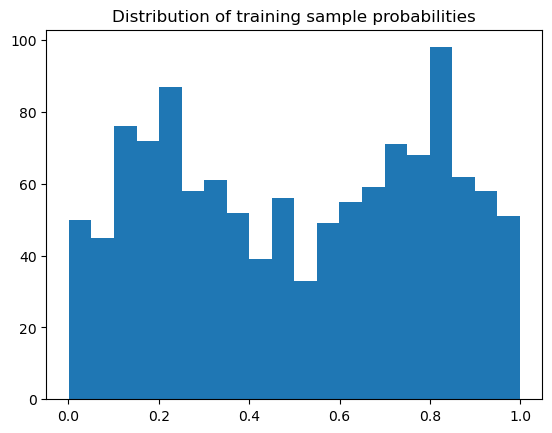

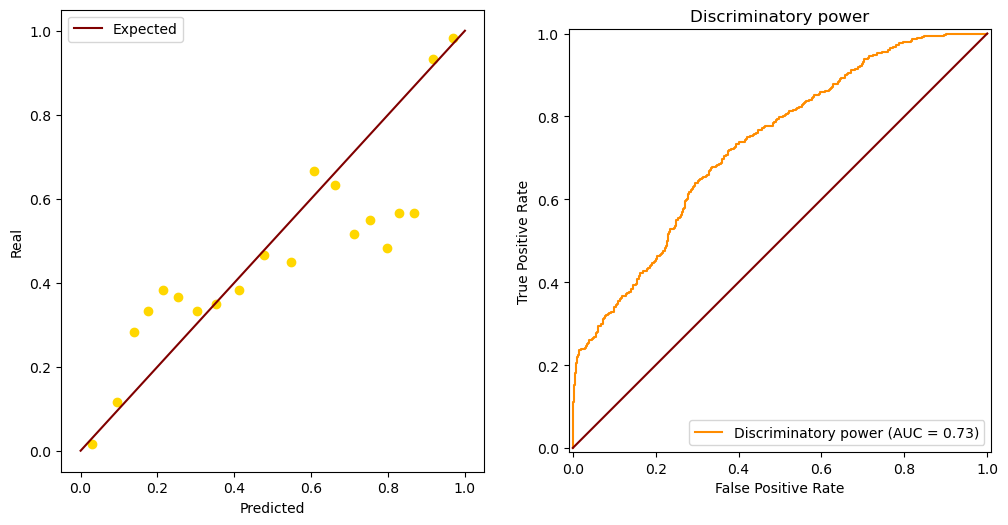

Best sigmoid: False

Wilcoxon scipy:
One sided: 0.27
Two sided: 0.55

T-test scipy:
One sided: 0.01
Two sided: 0.03

Hosmer-Lemshow:
Two sided: 0.0

Kolmogorow-Smirnov:
One sided: 0.29
Two sided: 0.57

MSE: 0.02194186056011323


,log_loss,brier_score,ECE,AUC,spearman
original,0.625375,0.219438,0.109,0.732084,0.921340
platt,0.602241,0.207390,0.105,0.741931,0.858224
iso,0.680380,0.199083,0.045,0.741283,0.950000


,log_loss,brier_score,ECE,AUC,spearman,Name
original,0.625375,0.219438,0.109,0.732084,0.921340,Train
platt,0.602241,0.207390,0.105,0.741931,0.858224,Train
iso,0.680380,0.199083,0.045,0.741283,0.950000,Train


In [549]:
# What happends in imbalanced classification problems?
prob = np.random.uniform(0,1,n)

y = ((prob + np.random.uniform(-1/2,1/2,n))>1/2).astype(int)
df = pd.DataFrame(data={"predicted": prob, "real": y})

# Add some instances with probability close to 0.8 belonging to class 0
prob2 = np.random.uniform(0.7,0.9,int(n/10))
df2 = pd.DataFrame(data={"predicted": prob2, "real": ((prob2 + np.random.uniform(-1/2,1/2,len(prob2)))<1/20).astype(int)})

# Add some instances with probability close to 0.2 belonging to class 1
prob2 = np.random.uniform(0.1,0.3,int(n/10))
df3 = pd.DataFrame(data={"predicted": prob2, "real": ((prob2 + np.random.uniform(-1/2,1/2,len(prob2)))>1/20).astype(int)})

df = pd.concat([df, df2, df3])
df = df.sample(frac=1).reset_index(drop=True)

prob = df["predicted"].to_numpy()
y = df["real"].to_numpy()

plt.hist(prob, bins=20)
plt.title("Distribution of training sample probabilities")
plt.show()




res = run_experiment(prob, y, buckets, fit=False)
res["Name"] = "Train"
res

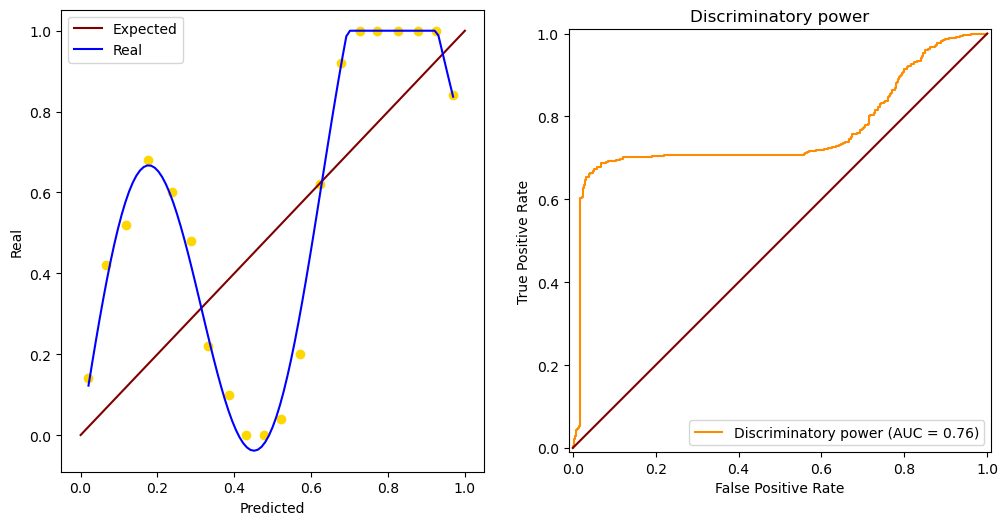

Best sigmoid: False

Wilcoxon scipy:
One sided: 0.7
Two sided: 0.62

T-test scipy:
One sided: 0.98
Two sided: 0.04

Hosmer-Lemshow:
Two sided: 0.0

Kolmogorow-Smirnov:
One sided: 0.64
Two sided: 0.57

MSE: 0.09264564592837207


,log_loss,brier_score,ECE,AUC,spearman
original,0.619371,0.203687,0.267,0.761151,0.602520
platt,0.581101,0.198653,0.265,0.767044,0.617106
iso,0.823729,0.143299,0.108,0.827737,0.828571


,log_loss,brier_score,ECE,AUC,spearman,Name
original,0.619371,0.203687,0.267,0.761151,0.602520,Train
platt,0.581101,0.198653,0.265,0.767044,0.617106,Train
iso,0.823729,0.143299,0.108,0.827737,0.828571,Train


In [554]:
# What happends in imbalanced classification problems?
prob = np.random.uniform(0,1,n)

y = ((np.sin(prob*10)/2+prob + np.random.uniform(-1/2,1/2,n))>1/2).astype(int)
df = pd.DataFrame(data={"predicted": prob, "real": y})





res = run_experiment(prob, y, buckets, fit=False, fun=lambda x: np.min([np.sin(x*10)/2+x,1]))
res["Name"] = "Train"
res